In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


# from sklearn.decomposition import PCA
from scipy import stats
# from sklearn.cluster import KMeans
# from sklearn import metrics
# from scipy.spatial.distance import cdist
# from sklearn.metrics import davies_bouldin_score

import pickle
import copy
# from shapely import geometry
# from sklearn.metrics.pairwise import euclidean_distances
# import statsmodels.api as sm
from scipy.stats import linregress
# from sklearn.metrics import accuracy_score
import math
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# from scipy.stats import ks_2samp

In [2]:
import string
abcd = list(string.ascii_lowercase)

In [3]:
names_reanalyses = ['ERA5',
                   'JRA3Q',
                   'NCEP_NCAR']

In [4]:
dic_labels = {}
for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../ProcessZ500/labels/df_labels_nocorrfilt_{reanalysis}.csv', parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp = labels_temp['1948':]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels[reanalysis] = labels_temp

In [5]:
dic_events = {}

for ir, reanalysis in enumerate(names_reanalyses):
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels[reanalysis])
    
    df_labels['season'] = df_labels.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_labels['season'] = df_labels['season'].map(season_map)
    
    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events[reanalysis] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_41423/2337241071.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_41423/2337241071.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_41423/2337241071.py:16: FutureWarning: A value

In [6]:
N=30

dic_stats_durations = {}
dic_dfs_durations = {}

for ir, reanalysis in enumerate(names_reanalyses):
    dic_stats_durations[reanalysis] = {}
    dic_dfs_durations[reanalysis] = {}
    start_year = dic_labels[reanalysis].index.year[0] + (N-1)
    end_year = dic_labels[reanalysis].index.year[-1]
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events[reanalysis])
        df_temp = df_temp[(df_temp['season']=='Winter')|(df_temp['season']=='Spring')]
        df_temp = df_temp[df_temp['WR']==wr]
        
        dic_stats_temp = {}
        dic_stats_temp['mean'] = []
        dic_stats_temp['std'] = []
        dic_stats_temp['p90'] = []
        dic_stats_temp['p10'] = []
        dic_stats_temp['p95'] = []
        dic_stats_temp['p05'] = []
        dic_stats_temp['n_events'] = []
        dic_stats_temp['n_days'] = []
        
        for year in range(start_year, end_year+1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))

            dic_stats_temp['n_events'].append(len(df_temp_temp)/30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum()/(30*365/2))
        df_stats_temp = pd.DataFrame(dic_stats_temp,index=np.arange(start_year,end_year+1))
        df_stats_temp.index = df_stats_temp.index-15
        dic_stats_durations[reanalysis][f'wr{wr}'] = df_stats_temp
        dic_dfs_durations[reanalysis][f'wr{wr}'] = df_temp

# read LENS2

In [7]:
files_lens2 = np.sort(glob.glob('../ProcessZ500/labels_lens2/*.csv'))

dic_labels_lens2 = {}

for file_temp in files_lens2:
    labels_temp = pd.read_csv(file_temp, parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels_lens2[file_temp.split('labels_')[-1][:-4]] = labels_temp

dic_events_lens2 = {}

for file_temp in files_lens2:
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels_lens2[file_temp.split('labels_')[-1][:-4]])

    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events_lens2[file_temp.split('labels_')[-1][:-4]] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_41423/2115786177.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_41423/2115786177.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_41423/2115786177.py:25: FutureWarning: A value

In [8]:
from multiprocessing import Pool

# Function to process each file and return results
def process_file(file_temp):
    print(file_temp)
    key = file_temp.split('labels_')[-1][:-4]
    dic_stats = {}
    dic_dfs = {}

    start_year = dic_labels_lens2[key].index.year[0] + (N-1)
    end_year = dic_labels_lens2[key].index.year[-1]
    
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events_lens2[key])
        df_temp = df_temp[(df_temp['season'] == 'Winter')|(df_temp['season'] == 'Spring')]
        df_temp = df_temp[df_temp['WR'] == wr]
        
        dic_stats_temp = {
            'mean': [],
            'std': [],
            'p90': [],
            'p10': [],
            'p95': [],
            'p05': [],
            'n_events': [],
            'n_days': []
        }
        
        for year in range(start_year, end_year + 1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))

            dic_stats_temp['n_events'].append(len(df_temp_temp) / 30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum() / (30 * 365 / 2))
        
        df_stats_temp = pd.DataFrame(dic_stats_temp, index=np.arange(start_year, end_year + 1))
        df_stats_temp.index=df_stats_temp.index-15
        dic_stats[f'wr{wr}'] = df_stats_temp
        dic_dfs[f'wr{wr}'] = df_temp
    
    return key, dic_stats, dic_dfs

# Use multiprocessing to parallelize the processing
if __name__ == '__main__':
    dic_stats_durations_lens2 = {}
    dic_dfs_durations_lens2 = {}

    with Pool() as pool:
        results = pool.map(process_file, files_lens2)

    # Collect results into the final dictionaries
    for key, dic_stats, dic_dfs in results:
        dic_stats_durations_lens2[key] = dic_stats
        dic_dfs_durations_lens2[key] = dic_dfs

    # You can now use dic_stats_durations_lens2 and dic_dfs_durations_lens2 as needed

../ProcessZ500/labels_lens2/df_labels_LE2-1021.002_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1031.002_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1041.003_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1051.003_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1061.004_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1071.004_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1081.005_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1091.005_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1101.006_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1111.006_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1121.007_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1131.007_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1141.008_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1151.008_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1161.009_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1181.010_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1191.

In [9]:
names_models = np.array([file_temp.split('labels_')[-1][:-4] for file_temp in files_lens2])

In [10]:
wr = 1

In [11]:
lens2listfreqsfull = []
for name_model in names_models:
    lens2listfreqsfull.append(dic_stats_durations_lens2[name_model][f'wr{wr}']['n_days'].values)

meanlens2 = pd.Series(np.mean(lens2listfreqsfull,axis=0),index=dic_stats_durations_lens2[name_model][f'wr{wr}'].index)

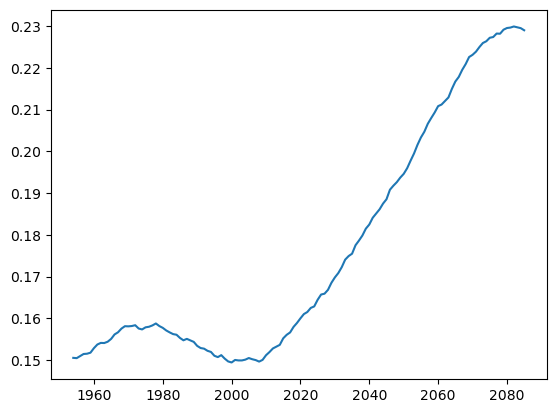

In [12]:
plt.plot(meanlens2)

In [13]:
# meanlens2.to_csv('meanlens2.csv')

In [14]:
colors_reanalyses = {'ERA5':'k','JRA3Q':'red','NCEP_NCAR':'blue'}

diffs_lens_past = []
diffs_lens_future = []

start_year = 1977-15
end_year = 2023-15

end_year_future = 2023+46-15
start_year_future = end_year_future - (end_year-start_year)
print(start_year_future)
for name_temp in names_models:
    df_stats_temp = dic_stats_durations_lens2[name_temp][f'wr{wr}']
    diffs_lens_past.append(df_stats_temp['n_days'][end_year]-df_stats_temp['n_days'][start_year])
    diffs_lens_future.append(df_stats_temp['n_days'][end_year_future]-df_stats_temp['n_days'][start_year_future])
diffs_lens_past = np.array(diffs_lens_past)
diffs_lens_future = np.array(diffs_lens_future)

2008


# CESM1-LR

In [15]:
files_cesm1lr = np.sort(glob.glob('../ProcessZ500/labels_cesm1lr/*.csv'))

dic_labels_cesm1lr = {}

for file_temp in files_cesm1lr:
    labels_temp = pd.read_csv(file_temp, parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels_cesm1lr[file_temp.split('labels_')[-1][:-4]] = labels_temp
    # aaaa

dic_events_cesm1lr = {}

for file_temp in files_cesm1lr:
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels_cesm1lr[file_temp.split('labels_')[-1][:-4]])

    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events_cesm1lr[file_temp.split('labels_')[-1][:-4]] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_41423/3911355940.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_41423/3911355940.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_41423/3911355940.py:26: FutureWarning: A value

In [16]:
from multiprocessing import Pool

# Function to process each file and return results
def process_file(file_temp):
    print(file_temp)
    key = file_temp.split('labels_')[-1][:-4]
    dic_stats = {}
    dic_dfs = {}

    start_year = dic_labels_cesm1lr[key].index.year[0] + (N-1)
    end_year = dic_labels_cesm1lr[key].index.year[-1]
    
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events_cesm1lr[key])
        df_temp = df_temp[(df_temp['season'] == 'Winter')|(df_temp['season'] == 'Spring')]
        df_temp = df_temp[df_temp['WR'] == wr]
        
        dic_stats_temp = {
            'mean': [],
            'std': [],
            'p90': [],
            'p10': [],
            'p95': [],
            'p05': [],
            'n_events': [],
            'n_days': []
        }
        
        for year in range(start_year, end_year + 1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))

            dic_stats_temp['n_events'].append(len(df_temp_temp) / 30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum() / (30 * 365 / 2))
        
        df_stats_temp = pd.DataFrame(dic_stats_temp, index=np.arange(start_year, end_year + 1))
        df_stats_temp.index=df_stats_temp.index-15
        dic_stats[f'wr{wr}'] = df_stats_temp
        dic_dfs[f'wr{wr}'] = df_temp
    
    return key, dic_stats, dic_dfs

# Use multiprocessing to parallelize the processing
if __name__ == '__main__':
    dic_stats_durations_cesm1lr = {}
    dic_dfs_durations_cesm1lr = {}

    with Pool() as pool:
        results = pool.map(process_file, files_cesm1lr)

    # Collect results into the final dictionaries
    for key, dic_stats, dic_dfs in results:
        dic_stats_durations_cesm1lr[key] = dic_stats
        dic_dfs_durations_cesm1lr[key] = dic_dfs

    # You can now use dic_stats_durations_lens2 and dic_dfs_durations_lens2 as needed

../ProcessZ500/labels_cesm1lr/df_labels_003.csv../ProcessZ500/labels_cesm1lr/df_labels_004.csv../ProcessZ500/labels_cesm1lr/df_labels_005.csv../ProcessZ500/labels_cesm1lr/df_labels_006.csv../ProcessZ500/labels_cesm1lr/df_labels_007.csv../ProcessZ500/labels_cesm1lr/df_labels_008.csv../ProcessZ500/labels_cesm1lr/df_labels_009.csv../ProcessZ500/labels_cesm1lr/df_labels_010.csv../ProcessZ500/labels_cesm1lr/df_labels_002.csv../ProcessZ500/labels_cesm1lr/df_labels_001.csv











In [17]:
names_models_cesm1lr = np.array([file_temp.split('labels_')[-1][:-4] for file_temp in files_cesm1lr])

In [18]:
wr = 1

In [19]:
cesm1lrlistfreqsfull = []
for name_model in names_models_cesm1lr:
    cesm1lrlistfreqsfull.append(dic_stats_durations_cesm1lr[name_model][f'wr{wr}']['n_days'].values)

meancesm1lr = pd.Series(np.mean(cesm1lrlistfreqsfull,axis=0),index=dic_stats_durations_cesm1lr[name_model][f'wr{wr}'].index)

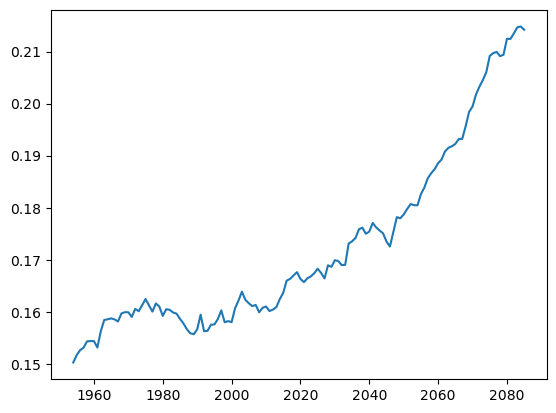

In [20]:
plt.plot(meancesm1lr)

In [21]:
cesm1lrcolors_reanalyses = {'ERA5':'k','JRA3Q':'red','NCEP_NCAR':'blue'}

diffs_cesm1lr_past = []

start_year = 1977-15
end_year = 2023-15

end_year_future = 2023+46-15
start_year_future = end_year_future - (end_year-start_year)
print(start_year_future)
for name_temp in names_models_cesm1lr:
    df_stats_temp = dic_stats_durations_cesm1lr[name_temp][f'wr{wr}']
    diffs_cesm1lr_past.append(df_stats_temp['n_days'][end_year]-df_stats_temp['n_days'][start_year])
diffs_cesm1lr_past = np.array(diffs_cesm1lr_past)

2008


# CESM1-LR

In [22]:
files_cesm1hr = np.sort(glob.glob('../ProcessZ500/labels_cesm1hr/*.csv'))

dic_labels_cesm1hr = {}

for file_temp in files_cesm1hr:
    labels_temp = pd.read_csv(file_temp, parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels_cesm1hr[file_temp.split('labels_')[-1][:-4]] = labels_temp
    # aaaa

dic_events_cesm1hr = {}

for file_temp in files_cesm1hr:
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels_cesm1hr[file_temp.split('labels_')[-1][:-4]])

    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events_cesm1hr[file_temp.split('labels_')[-1][:-4]] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_41423/675933415.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_41423/675933415.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_41423/675933415.py:26: FutureWarning: A value is

In [23]:
from multiprocessing import Pool

# Function to process each file and return results
def process_file(file_temp):
    print(file_temp)
    key = file_temp.split('labels_')[-1][:-4]
    dic_stats = {}
    dic_dfs = {}

    start_year = dic_labels_cesm1hr[key].index.year[0] + (N-1)
    end_year = dic_labels_cesm1hr[key].index.year[-1]
    
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events_cesm1hr[key])
        df_temp = df_temp[(df_temp['season'] == 'Winter')|(df_temp['season'] == 'Spring')]
        df_temp = df_temp[df_temp['WR'] == wr]
        
        dic_stats_temp = {
            'mean': [],
            'std': [],
            'p90': [],
            'p10': [],
            'p95': [],
            'p05': [],
            'n_events': [],
            'n_days': []
        }
        
        for year in range(start_year, end_year + 1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))

            dic_stats_temp['n_events'].append(len(df_temp_temp) / 30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum() / (30 * 365 / 2))
        
        df_stats_temp = pd.DataFrame(dic_stats_temp, index=np.arange(start_year, end_year + 1))
        df_stats_temp.index=df_stats_temp.index-15
        dic_stats[f'wr{wr}'] = df_stats_temp
        dic_dfs[f'wr{wr}'] = df_temp
    
    return key, dic_stats, dic_dfs

# Use multiprocessing to parallelize the processing
if __name__ == '__main__':
    dic_stats_durations_cesm1hr = {}
    dic_dfs_durations_cesm1hr = {}

    with Pool() as pool:
        results = pool.map(process_file, files_cesm1hr)

    # Collect results into the final dictionaries
    for key, dic_stats, dic_dfs in results:
        dic_stats_durations_cesm1hr[key] = dic_stats
        dic_dfs_durations_cesm1hr[key] = dic_dfs

    # You can now use dic_stats_durations_lens2 and dic_dfs_durations_lens2 as needed

../ProcessZ500/labels_cesm1hr/df_labels_004.csv../ProcessZ500/labels_cesm1hr/df_labels_005.csv../ProcessZ500/labels_cesm1hr/df_labels_006.csv../ProcessZ500/labels_cesm1hr/df_labels_007.csv../ProcessZ500/labels_cesm1hr/df_labels_008.csv../ProcessZ500/labels_cesm1hr/df_labels_010.csv../ProcessZ500/labels_cesm1hr/df_labels_003.csv../ProcessZ500/labels_cesm1hr/df_labels_002.csv









In [24]:
names_models_cesm1hr = np.array([file_temp.split('labels_')[-1][:-4] for file_temp in files_cesm1hr])

In [25]:
wr = 1

In [26]:
cesm1hrlistfreqsfull = []
for name_model in names_models_cesm1hr:
    cesm1hrlistfreqsfull.append(dic_stats_durations_cesm1hr[name_model][f'wr{wr}']['n_days'].values)

meancesm1hr = pd.Series(np.mean(cesm1hrlistfreqsfull,axis=0),index=dic_stats_durations_cesm1hr[name_model][f'wr{wr}'].index)

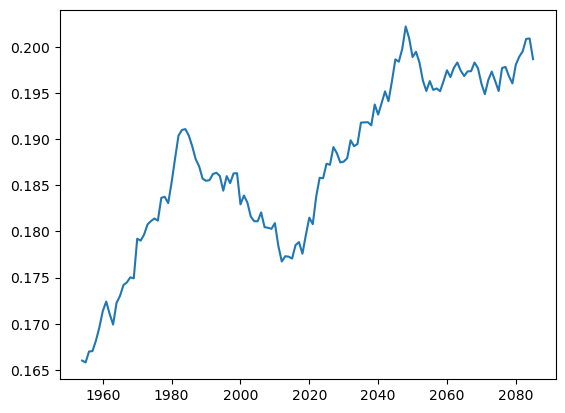

In [27]:
plt.plot(meancesm1hr)

In [28]:
cesm1hrcolors_reanalyses = {'ERA5':'k','JRA3Q':'red','NCEP_NCAR':'blue'}

diffs_cesm1hr_past = []

start_year = 1977-15
end_year = 2023-15

end_year_future = 2023+46-15
start_year_future = end_year_future - (end_year-start_year)
print(start_year_future)
for name_temp in names_models_cesm1hr:
    df_stats_temp = dic_stats_durations_cesm1hr[name_temp][f'wr{wr}']
    diffs_cesm1hr_past.append(df_stats_temp['n_days'][end_year]-df_stats_temp['n_days'][start_year])
diffs_cesm1hr_past = np.array(diffs_cesm1hr_past)

2008


# Figure

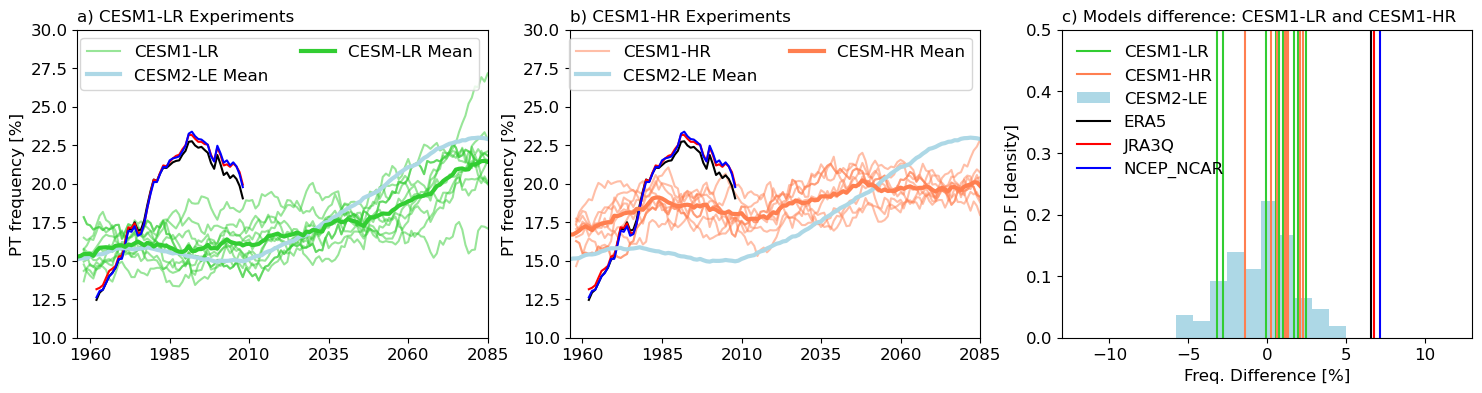

In [39]:
start_year = 1977-15
end_year = 2023-15

fig, axs = plt.subplots(1, 3, figsize=(18, 4))
axs_list = axs.flatten().tolist()
fontsize = 12
colors_forcings = ['brown','green','orange','black']
####### CESM1LR ######
ax=axs_list[0]

for name_temp in names_models_cesm1lr:
    ax.plot(dic_stats_durations_cesm1lr[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year-4}':]*100,color='limegreen',alpha=0.5)
ax.plot(dic_stats_durations_cesm1lr[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year-4}':]*100,color='limegreen',alpha=0.5,label='CESM1-LR')

ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue')
ax.plot(meanlens2*100,color='lightblue',lw=3,label='CESM2-LE Mean')
ax.plot(meancesm1lr*100,color='limegreen',lw=3,label='CESM-LR Mean')

ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15-4,2100-15)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('a) CESM1-LR Experiments',loc='left',fontsize=fontsize)

####### CESM1HR ######
ax=axs_list[1]

for name_temp in names_models_cesm1hr:
    ax.plot(dic_stats_durations_cesm1hr[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year-4}':]*100,color='coral',alpha=0.5)
ax.plot(dic_stats_durations_cesm1hr[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year-4}':]*100,color='coral',alpha=0.5,label='CESM1-HR')

ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue')
ax.plot(meanlens2*100,color='lightblue',lw=3,label='CESM2-LE Mean')
ax.plot(meancesm1hr*100,color='coral',lw=3,label='CESM-HR Mean')

ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15-4,2100-15)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('b) CESM1-HR Experiments',loc='left',fontsize=fontsize)


#### Hist ###

ax=axs_list[2]

for i in range(len(diffs_cesm1lr_past)):
    if i==len(diffs_cesm1lr_past)-1:
        ax.axvline(diffs_cesm1lr_past[i]*100,color='limegreen',label='CESM1-LR')
    else:
        ax.axvline(diffs_cesm1lr_past[i]*100,color='limegreen')

for i in range(len(diffs_cesm1hr_past)):
    if i==len(diffs_cesm1hr_past)-1:
        ax.axvline(diffs_cesm1hr_past[i]*100,color='coral',label='CESM1-HR')
    else:
        ax.axvline(diffs_cesm1hr_past[i]*100,color='coral')

ax.hist(diffs_lens_past*100,alpha=1,label='CESM2-LE',density=True,color='lightblue')

for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)

ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_xlim(-13,13)
ax.set_ylim(0,0.5)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,loc='upper left',framealpha=0.0)
ax.set_title('c) Models difference: CESM1-LR and CESM1-HR',fontsize=fontsize,loc='left')
plt.savefig('nFigures/CESMLR_HR_PT.png',bbox_inches='tight')